## Calculating recall in hours to sepsis onset for the best models

Sections:
- Imports
- LSTM Class
- Calculcate HoursBeforeOnset
    - Examine trends between selected variables and ICULOS (time)
    - Prepare dataloaders
    - Calculate and plot recall scores


### Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import math
import re
import sys
import pickle
from tqdm import tqdm
import warnings

# PyTorch
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torchmetrics.functional.regression import symmetric_mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader

# Optuna
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from packaging import version

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_auc_score, average_recall_score, balanced_accuracy_score
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# Scipy
from scipy.interpolate import interp1d

# Visualization
import seaborn as sn
sn.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
from datetime import datetime
import plotly.figure_factory as ff
import shap

device = 'cpu'

### LSTM Class 

In [57]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, in_size, h_size, num_l, out_f, dropout_rate, activ):
        super().__init__()
        self.input_size = in_size
        self.hidden_size = h_size
        self.num_layers = num_l
        self.out_features = out_f
        self.dropout_rate = dropout_rate
        self.activ = activ
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=self.dropout_rate
                            )
        self.linear1 = nn.Linear(in_features=self.hidden_size,
                                 out_features=self.out_features)

    def forward(self, X):
        X, _ = self.lstm(X)
        # Picking the last output
        X = self.activ(X[:,-1,:])
        X = self.linear1(X)

        return X
    
    

In [63]:
import lightgbm
import pickle

# Import best boosting model for clinical measurements (catboost  )
with open('models_nn_all/sepsis_cat.pkl', 'rb') as f:
    best_catboost_model = pickle.load(f)

# Import best NN model capturing time effect (lstm)
with open('models_nn_all/sepsis_lstm.pkl', 'rb') as f:
    best_lstm_model = pickle.load(f)

### Calculate HoursBeforeOnset

Examine trends between selected variables and ICULOS (length of stay)

In [2]:
org_df = pd.read_csv("data/all/all_processed_sepsis_df_with_org.csv")

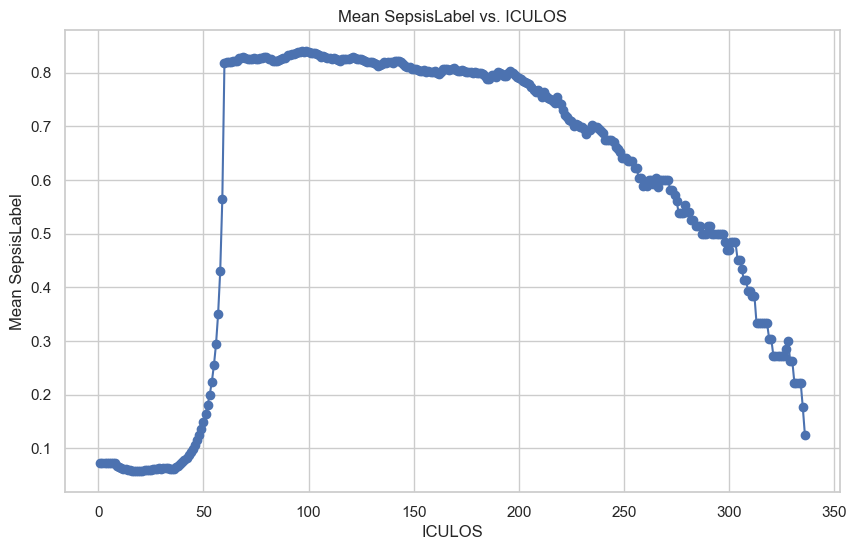

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("data/all/all_sample_data_target_recode.csv")


# Ensure that the 'ICULOS' column is sorted if necessary
df = df.sort_values('ICULOS')


# Group by the 'ICULOS' column and calculate the mean of the 'SepsisLabel' column
mean_sepsis_by_iculos = df.groupby('ICULOS')['SepsisLabel'].mean()

# Plotting the mean 'SepsisLabel' against 'ICULOS'
plt.figure(figsize=(10, 6))
plt.plot(mean_sepsis_by_iculos.index, mean_sepsis_by_iculos.values, marker='o', linestyle='-')
plt.xlabel('ICULOS')
plt.ylabel('Mean SepsisLabel')
plt.title('Mean SepsisLabel vs. ICULOS')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df=org_df


# Ensure that the 'O2Sat' column is sorted if necessary
df = df.sort_values('ICULOS')


# Group by the 'O2Sat' column and calculate the mean of the 'SepsisLabel' column
mean_sepsis_by_iculos = df.groupby('ICULOS')['O2Sat'].mean()

# Plotting the mean 'SepsisLabel' against 'O2Sat'
plt.figure(figsize=(10, 6))
plt.plot(mean_sepsis_by_iculos.index, mean_sepsis_by_iculos.values, linestyle='-')
plt.xlabel('ICULOS')
plt.ylabel('Mean O2Sat')
plt.title('Mean O2Sat vs. ICULOS')
plt.grid(True)
plt.show()

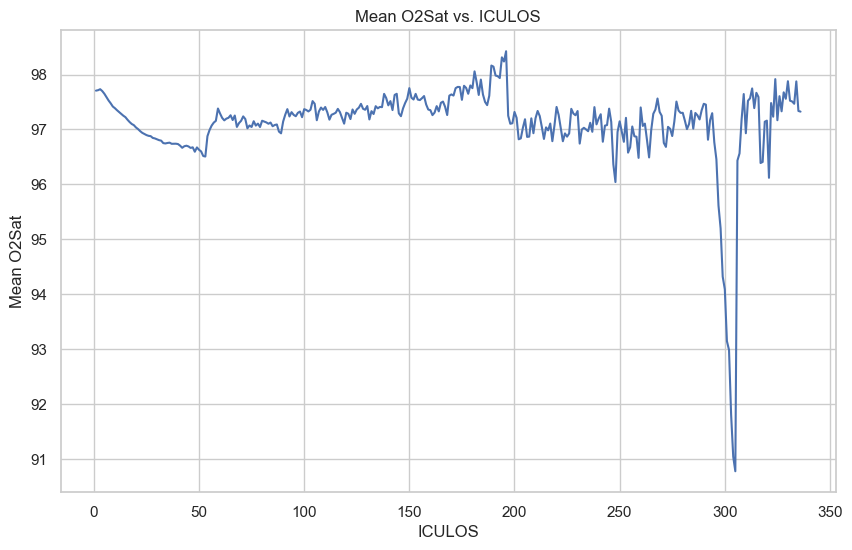

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
df=org_df


# Ensure that the 'O2Sat' column is sorted if necessary
df = df.sort_values('ICULOS')


# Group by the 'O2Sat' column and calculate the mean of the 'SepsisLabel' column
mean_sepsis_by_iculos = df.groupby('ICULOS')['O2Sat'].mean()

# Plotting the mean 'SepsisLabel' against 'O2Sat'
plt.figure(figsize=(10, 6))
plt.plot(mean_sepsis_by_iculos.index, mean_sepsis_by_iculos.values, linestyle='-')
plt.xlabel('ICULOS')
plt.ylabel('Mean O2Sat')
plt.title('Mean O2Sat vs. ICULOS')
plt.grid(True)
plt.show()

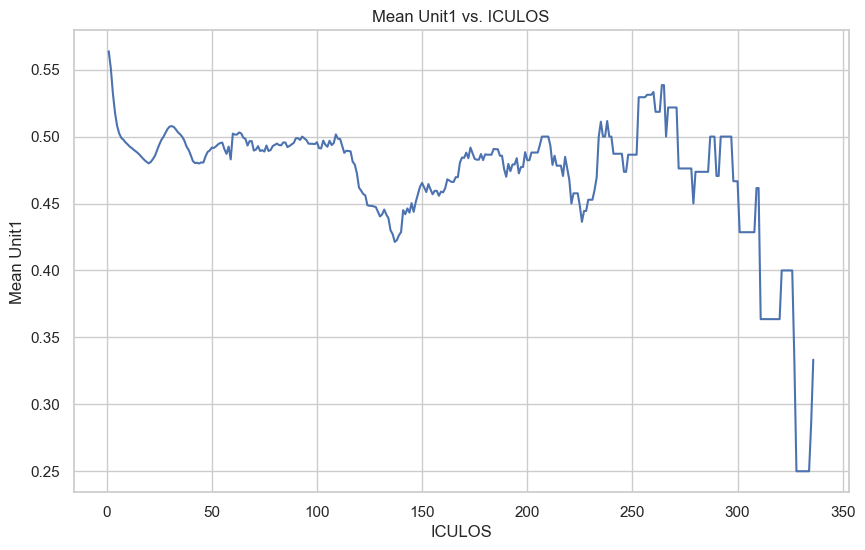

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
df=org_df


# Ensure that the 'O2Sat' column is sorted if necessary
df = df.sort_values('ICULOS')


# Group by the 'O2Sat' column and calculate the mean of the 'SepsisLabel' column
mean_sepsis_by_iculos = df.groupby('ICULOS')['Unit1'].mean()

# Plotting the mean 'SepsisLabel' against 'O2Sat'
plt.figure(figsize=(10, 6))
plt.plot(mean_sepsis_by_iculos.index, mean_sepsis_by_iculos.values, linestyle='-')
plt.xlabel('ICULOS')
plt.ylabel('Mean Unit1')
plt.title('Mean Unit1 vs. ICULOS')
plt.grid(True)
plt.show()

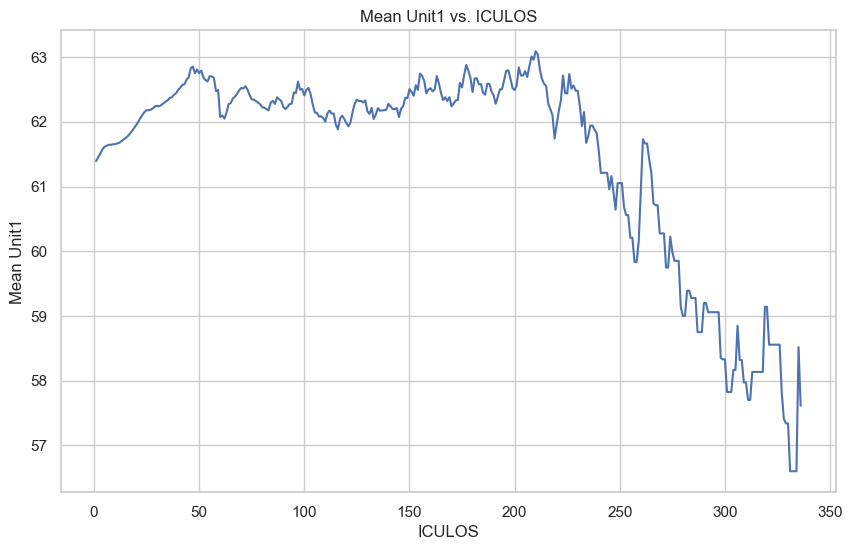

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
df=org_df


# Ensure that the 'O2Sat' column is sorted if necessary
df = df.sort_values('ICULOS')


# Group by the 'O2Sat' column and calculate the mean of the 'SepsisLabel' column
mean_sepsis_by_iculos = df.groupby('ICULOS')['Age'].mean()

# Plotting the mean 'SepsisLabel' against 'O2Sat'
plt.figure(figsize=(10, 6))
plt.plot(mean_sepsis_by_iculos.index, mean_sepsis_by_iculos.values, linestyle='-')
plt.xlabel('ICULOS')
plt.ylabel('Mean Age')
plt.title('Mean Unit1 vs. ICULOS')
plt.grid(True)
plt.show()

In [9]:
# Initialize the HoursBeforeOnset column with a large number (10000)
org_df['HoursBeforeOnset'] = 10000

# Iterate over each patient ID group
for patient_id, group in org_df.groupby('File_Path'):
    # Find the index where SepsisLabel first turns 1
    onset_index = group.index[group['SepsisLabelOrg'] == 1].min()
    
    if pd.notna(onset_index):
        # Calculate the hours before onset for each observation
        org_df.loc[group.index, 'HoursBeforeOnset'] = group.loc[onset_index, 'ICULOS'] - group['ICULOS']
    else:
        # If no onset found (patient didn't have sepsis), keep the default value (10000)
        org_df.loc[group.index, 'HoursBeforeOnset'] = 10000

# Sort dataframe back to its original order (if needed)
org_df = org_df.sort_index()

In [11]:

# Group by patient_id and check if any SepsisLabel is 1 for each patient
patients_with_sepsis = org_df.loc[org_df['SepsisLabel'] == 1, 'File_Path'].unique()

# Group by patient_id and check if no SepsisLabel is 1 for each patient
patients_without_sepsis = org_df.loc[org_df['SepsisLabel'] == 0, 'File_Path'].unique()

In [18]:
org_df.to_csv("data/all/all_processed_sepsis_df_hours_before_onset.csv", index=False)

Prepare dataloaders

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import dataloader_wrapper_cuda
from tqdm import tqdm
import importlib

your_module = importlib.reload(dataloader_wrapper_cuda)

# Load the scaler from a pickle file
scaler_filename = os.path.join('scalers_imputers_for_sample_all', 'min_max_scaler_all_feat.pkl')
with open(scaler_filename, 'rb') as file:
    scaler = pickle.load(file)

# # Load the imputer from a pickle file
imputer_filename = os.path.join('scalers_imputers_for_sample_all', 'bayesian_imputer_all_feat.pkl')
with open(imputer_filename, 'rb') as file:
    imputer = pickle.load(file)
    
dataloader1 = dataloader_wrapper_cuda.SepsisDataLoader(train_dir="data/all/all_sample_data_target_recode.csv",
                          seq_len=20,
                          X_scaler=scaler,
                          X_imputer=imputer,
                          test_size=0.3,
                          random_state=42,
                          batch_size=256,
                          training_size=1,
                          num_workers=6,
                          device=device
                          )
dataloader1.prepare_for_training()

cols = dataloader1.columns_to_keep

train val test id nums 28234 6051 6051
uniq filepaths, len filepaths 40336 1552210
flag0 (1087188, 53) (233589, 53) (231433, 53)


100%|██████████| 6051/6051 [00:13<00:00, 449.88it/s]


In [64]:
import dataloader_wrapper_cuda_org_lab
import importlib

your_module = importlib.reload(dataloader_wrapper_cuda_org_lab)

dataloader_org = dataloader_wrapper_cuda_org_lab.SepsisDataLoader(train_dir="data/all/all_processed_sepsis_df_hours_before_onset.csv",
                          seq_len=20,
                          X_scaler=scaler,
                          X_imputer=imputer,
                          test_size=0.3,
                          random_state=42,
                          batch_size=256,
                          training_size=1,
                          num_workers=6,
                          device=device
                          )
dataloader_org.prepare_for_training()

test_lstm_predictions = []
test_catboost_predictions = [] 
test_labels = []
original_labels = []
hours_before_onset = []
with torch.no_grad():
        for (data1, data2) in zip(dataloader1.test_dataloader(), dataloader_org.test_dataloader()):
            
                inputs1, labels = data1
                inputs2, _ = data1
                org_labels, h_before_onset = data2
                # Forward pass through base models
                outputs1 = torch.sigmoid(best_lstm_model(inputs1).squeeze())
                outputs2 = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                
                # Forward pass through meta-model
                # meta_outputs = meta_model(outputs1, outputs2)

                # Collect predictions and labels for test set
                test_lstm_predictions.extend(outputs1.detach().numpy())
                test_catboost_predictions.extend(outputs2.detach().numpy())
                test_labels.extend(labels.cpu().numpy())
                original_labels.extend(org_labels[:,-1, :].cpu().numpy())
                hours_before_onset.extend(h_before_onset.cpu().numpy())

train val test id nums 28234 6051 6051
uniq filepaths, len filepaths 40336 1552210
flag0 (1087188, 5) (233589, 5) (231433, 5)


100%|██████████| 6051/6051 [00:08<00:00, 721.33it/s]


Calculate and plot recall scores

In [ ]:
from sklearn.metrics import recall_score
import numpy as np

# Initialize dictionaries to store recall scores
recall_lstm = {}
recall_catboost = {}

# Define hour ranges
hour_ranges = range(-1, 150)

# Calculate recall for each hour range for both models
for hour in hour_ranges:
    indices = np.where((np.array(hours_before_onset) >= hour) & (np.array(hours_before_onset) < hour + 10))[0]
    
    if len(indices) > 0:
        # Calculate recall for model 1
        recall_lstm[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_lstm_predictions)[indices]>= 0.73).astype(int))
        
        # Calculate recall for model 2
        recall_catboost[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_catboost_predictions)[indices]>= 0.76).astype(int))

# Print recall scores for both models
print("Test Recall for LSTM:")
for hour, recall in recall_lstm.items():
    print(f"Hours {hour}-{hour+1}: {recall:.2f}")

print("\nTest Recall for CatBoost:")
for hour, recall in recall_catboost.items():
    print(f"Hours {hour}-{hour+1}: {recall:.2f}")

Test Recall for LSTM:
Hours -1-0: 0.60
Hours 0-1: 0.60
Hours 1-2: 0.60
Hours 2-3: 0.61
Hours 3-4: 0.61
Hours 4-5: 0.61
Hours 5-6: 0.61
Hours 6-7: 0.61
Hours 7-8: 0.62
Hours 8-9: 0.62
Hours 9-10: 0.62
Hours 10-11: 0.61
Hours 11-12: 0.61
Hours 12-13: 0.62
Hours 13-14: 0.62
Hours 14-15: 0.62
Hours 15-16: 0.62
Hours 16-17: 0.62
Hours 17-18: 0.62
Hours 18-19: 0.63
Hours 19-20: 0.63
Hours 20-21: 0.64
Hours 21-22: 0.64
Hours 22-23: 0.64
Hours 23-24: 0.65
Hours 24-25: 0.65
Hours 25-26: 0.64
Hours 26-27: 0.64
Hours 27-28: 0.64
Hours 28-29: 0.64
Hours 29-30: 0.63
Hours 30-31: 0.63
Hours 31-32: 0.62
Hours 32-33: 0.62
Hours 33-34: 0.61
Hours 34-35: 0.61
Hours 35-36: 0.61
Hours 36-37: 0.60
Hours 37-38: 0.60
Hours 38-39: 0.60
Hours 39-40: 0.60
Hours 40-41: 0.60
Hours 41-42: 0.60
Hours 42-43: 0.61
Hours 43-44: 0.61
Hours 44-45: 0.62
Hours 45-46: 0.62
Hours 46-47: 0.62
Hours 47-48: 0.62
Hours 48-49: 0.62
Hours 49-50: 0.62
Hours 50-51: 0.62
Hours 51-52: 0.62
Hours 52-53: 0.62
Hours 53-54: 0.62
Hours 54

In [ ]:
from sklearn.metrics import recall_score
import numpy as np

# Initialize dictionaries to store recall scores
recall_lstm = {}
recall_catboost = {}

# Define hour ranges
hour_ranges = range(-1,300,10)

# Calculate recall for each hour range for both models
for hour in hour_ranges:
    indices = np.where((np.array(hours_before_onset) >= hour) & (np.array(hours_before_onset) < hour + 10))[0]
    
    if len(indices) > 0:
        # Calculate recall for model 1
        recall_lstm[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_lstm_predictions)[indices]>= 0.64).astype(int))
        
        # Calculate recall for model 2
        recall_catboost[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_catboost_predictions)[indices]>= 0.60).astype(int))

# Print recall scores for both models
print("Test Recall for LSTM:")
for hour, recall in recall_lstm.items():
    print(f"Hours {hour}-{hour+10}: {recall:.2f}")

print("\nTest Recall for CatBoost:")
for hour, recall in recall_catboost.items():
    print(f"Hours {hour}-{hour+10}: {recall:.2f}")

Test Recall for LSTM:
Hours -1-9: 0.64
Hours 9-19: 0.66
Hours 19-29: 0.69
Hours 29-39: 0.69
Hours 39-49: 0.64
Hours 49-59: 0.66
Hours 59-69: 0.68
Hours 69-79: 0.71
Hours 79-89: 0.72
Hours 89-99: 0.75
Hours 99-109: 0.75
Hours 109-119: 0.76
Hours 119-129: 0.70
Hours 129-139: 0.71
Hours 139-149: 0.63
Hours 149-159: 0.63
Hours 159-169: 0.59
Hours 169-179: 0.54
Hours 179-189: 0.44
Hours 189-199: 0.46
Hours 199-209: 0.49
Hours 209-219: 0.51
Hours 219-229: 0.56
Hours 229-239: 0.40
Hours 239-249: 0.34
Hours 249-259: 0.25
Hours 259-269: 0.25
Hours 269-279: 0.19
Hours 279-289: 0.00
Hours 289-299: 0.00
Hours 299-309: 0.00

Test Recall for CatBoost:
Hours -1-9: 0.71
Hours 9-19: 0.72
Hours 19-29: 0.76
Hours 29-39: 0.80
Hours 39-49: 0.78
Hours 49-59: 0.77
Hours 59-69: 0.75
Hours 69-79: 0.78
Hours 79-89: 0.80
Hours 89-99: 0.82
Hours 99-109: 0.81
Hours 109-119: 0.85
Hours 119-129: 0.83
Hours 129-139: 0.81
Hours 139-149: 0.80
Hours 149-159: 0.81
Hours 159-169: 0.71
Hours 169-179: 0.62
Hours 179-189: 0.

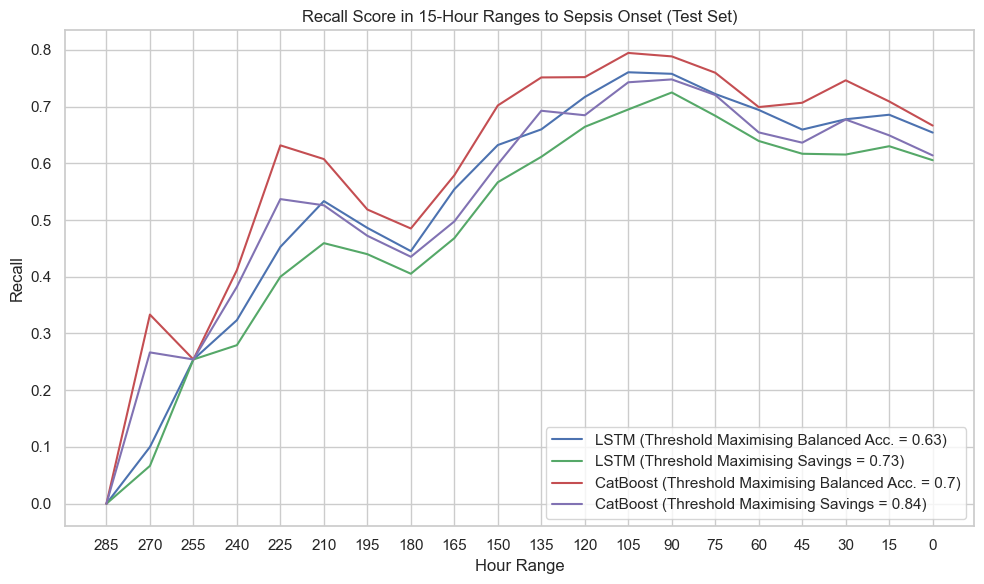

In [70]:
from sklearn.metrics import recall_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize dictionaries to store recall scores
recall_lstm_1 = {}
recall_lstm_2 = {}
recall_catboost_1 = {}
recall_catboost_2 = {}

# Define hour ranges
hour_ranges = range(0, 300, 15)

# Calculate recall for each hour range for LSTM model with two pairs of thresholds
for hour in hour_ranges:
    indices = np.where((np.array(hours_before_onset) >= hour) & (np.array(hours_before_onset) < hour + 15))[0]
    
    if len(indices) > 0:
        # Calculate recall for LSTM model with first pair of thresholds (0.64)
        recall_lstm_1[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_lstm_predictions)[indices] >= 0.63).astype(int))
        
        # Calculate recall for LSTM model with second pair of thresholds (0.73)
        recall_lstm_2[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_lstm_predictions)[indices] >= 0.73).astype(int))

# Calculate recall for each hour range for CatBoost model with two pairs of thresholds
for hour in hour_ranges:
    indices = np.where((np.array(hours_before_onset) >= hour) & (np.array(hours_before_onset) < hour + 15))[0]
    
    if len(indices) > 0:
        # Calculate recall for CatBoost model with first pair of thresholds (0.6)
        recall_catboost_1[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_catboost_predictions)[indices] >= 0.7).astype(int))
        
        # Calculate recall for CatBoost model with second pair of thresholds (0.74)
        recall_catboost_2[hour] = recall_score(np.array(test_labels).astype(int)[indices], (np.array(test_catboost_predictions)[indices] >= 0.84).astype(int))

# Plotting
plt.figure(figsize=(10, 6))

# Plot recall scores for LSTM model with first pair of thresholds
plt.plot(list(recall_lstm_1.keys()), list(recall_lstm_1.values()), linestyle='-', color='b', label='LSTM (Threshold Maximising Balanced Acc. = 0.63)')

# Plot recall scores for LSTM model with second pair of thresholds
plt.plot(list(recall_lstm_2.keys()), list(recall_lstm_2.values()),  linestyle='-', color='g', label='LSTM (Threshold Maximising Savings = 0.73)')

# Plot recall scores for CatBoost model with first pair of thresholds
plt.plot(list(recall_catboost_1.keys()), list(recall_catboost_1.values()), linestyle='-', color='r', label='CatBoost (Threshold Maximising Balanced Acc. = 0.7)')

# Plot recall scores for CatBoost model with second pair of thresholds
plt.plot(list(recall_catboost_2.keys()), list(recall_catboost_2.values()),  linestyle='-', color='m', label='CatBoost (Threshold Maximising Savings = 0.84)')

plt.xlabel('Hour Range')
plt.ylabel('Recall')
plt.title('Recall Score in 15-Hour Ranges to Sepsis Onset (Test Set)')
plt.xticks(list(recall_lstm_1.keys()))
plt.gca().invert_xaxis()
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()

# Show plot
plt.show()


In [38]:
import dataloader_wrapper_cuda_org_lab
import importlib

val_lstm_predictions = []
val_catboost_predictions = [] 
val_labels = []
original_labels = []
val_hours_before_onset = []
with torch.no_grad():
        for (data1, data2) in zip(dataloader1.val_dataloader(), dataloader_org.val_dataloader()):
            
                inputs1, labels = data1
                inputs2, _ = data1
                org_labels, h_before_onset = data2
                # Forward pass through base models
                outputs1 = torch.sigmoid(best_lstm_model(inputs1).squeeze())
                outputs2 = torch.Tensor(best_catboost_model.predict_proba(inputs2[:,-1, :].detach().numpy())[:, 1]).unsqueeze(1)
                
                # Forward pass through meta-model
                # meta_outputs = meta_model(outputs1, outputs2)

                # Collect predictions and labels for test set
                val_lstm_predictions.extend(outputs1.detach().numpy())
                val_catboost_predictions.extend(outputs2.detach().numpy())
                val_labels.extend(labels.cpu().numpy())
                original_labels.extend(org_labels[:,-1, :].cpu().numpy())
                val_hours_before_onset.extend(h_before_onset.cpu().numpy())

In [ ]:
from sklearn.metrics import recall_score
import numpy as np

# Initialize dictionaries to store recall scores
recall_lstm = {}
recall_catboost = {}

# Define hour ranges
hour_ranges = range(-1, 300)

# Calculate recall for each hour range for both models
for hour in hour_ranges:
    indices = np.where((np.array(val_hours_before_onset) == hour))[0]
    
    if len(indices) > 0:
        # Calculate recall for model 1
        recall_lstm[hour] = recall_score(np.array(val_labels).astype(int)[indices], (np.array(val_lstm_predictions)[indices]>= 0.64).astype(int))
        
        # Calculate recall for model 2
        recall_catboost[hour] = recall_score(np.array(val_labels).astype(int)[indices], (np.array(val_catboost_predictions)[indices]>= 0.60).astype(int))

# Print recall scores for both models
print("Validation Recall for LSTM:")
for hour, recall in recall_lstm.items():
    print(f"Hours {hour}-{hour+1}: {recall:.2f}")

print("\nValidation Recall for CatBoost:")
for hour, recall in recall_catboost.items():
    print(f"Hours {hour}-{hour+1}: {recall:.2f}")

Validation Recall for LSTM:
Hours -1-0: 0.59
Hours 0-1: 0.59
Hours 1-2: 0.59
Hours 2-3: 0.59
Hours 3-4: 0.57
Hours 4-5: 0.57
Hours 5-6: 0.58
Hours 6-7: 0.61
Hours 7-8: 0.61
Hours 8-9: 0.58
Hours 9-10: 0.58
Hours 10-11: 0.57
Hours 11-12: 0.58
Hours 12-13: 0.59
Hours 13-14: 0.59
Hours 14-15: 0.58
Hours 15-16: 0.60
Hours 16-17: 0.60
Hours 17-18: 0.61
Hours 18-19: 0.61
Hours 19-20: 0.62
Hours 20-21: 0.62
Hours 21-22: 0.61
Hours 22-23: 0.62
Hours 23-24: 0.61
Hours 24-25: 0.61
Hours 25-26: 0.61
Hours 26-27: 0.63
Hours 27-28: 0.61
Hours 28-29: 0.63
Hours 29-30: 0.64
Hours 30-31: 0.65
Hours 31-32: 0.65
Hours 32-33: 0.64
Hours 33-34: 0.65
Hours 34-35: 0.64
Hours 35-36: 0.64
Hours 36-37: 0.64
Hours 37-38: 0.66
Hours 38-39: 0.64
Hours 39-40: 0.65
Hours 40-41: 0.63
Hours 41-42: 0.63
Hours 42-43: 0.67
Hours 43-44: 0.66
Hours 44-45: 0.65
Hours 45-46: 0.69
Hours 46-47: 0.67
Hours 47-48: 0.68
Hours 48-49: 0.67
Hours 49-50: 0.65
Hours 50-51: 0.62
Hours 51-52: 0.66
Hours 52-53: 0.64
Hours 53-54: 0.63
Ho

0.73, 0.76 - best thresh lstm catboost
0.64, 0.60 - best thresh for balanace acc lstm catboost